In [1]:
import torch 
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch.utils.data

In [2]:
#%% Device config
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)

Device:  cpu


In [3]:
#%% Dataset
def read_images(path, num_img):
    array = np.zeros([num_img,64*32])
    i = 0
    for img in os.listdir(path):
        img_path = path + "\\" + img
        img = Image.open(img_path, mode = 'r')
        data = np.asarray(img,dtype = "uint8")
        data = data.flatten()
        array[i,:] = data
        i += 1      
    return array

In [4]:
# read train negative  43390
train_negative_path = r"LSIFIR\Classification\Train\neg"
num_train_negative_img = 43390
train_negative_array = read_images(train_negative_path,num_train_negative_img)
x_train_negative_tensor = torch.from_numpy(train_negative_array[:42000,:])
print("x_train_negative_tensor: ",x_train_negative_tensor.size())
y_train_negative_tensor = torch.zeros(42000,dtype = torch.long)
print("y_train_negative_tensor: ",y_train_negative_tensor.size())

x_train_negative_tensor:  torch.Size([42000, 2048])
y_train_negative_tensor:  torch.Size([42000])


In [5]:
# read train positive 10208
train_positive_path = r"LSIFIR\Classification\Train\pos"
num_train_positive_img = 10208
train_positive_array = read_images(train_positive_path,num_train_positive_img)
x_train_positive_tensor = torch.from_numpy(train_positive_array[:10000,:])
print("x_train_positive_tensor: ",x_train_positive_tensor.size())
y_train_positive_tensor = torch.ones(10000,dtype = torch.long)
print("y_train_positive_tensor: ",y_train_positive_tensor.size())

x_train_positive_tensor:  torch.Size([10000, 2048])
y_train_positive_tensor:  torch.Size([10000])


In [6]:
# concat train
x_train = torch.cat((x_train_negative_tensor, x_train_positive_tensor), 0)
y_train = torch.cat((y_train_negative_tensor, y_train_positive_tensor), 0)
print("x_train: ",x_train.size())
print("y_train: ",y_train.size())

x_train:  torch.Size([52000, 2048])
y_train:  torch.Size([52000])


In [7]:
# read test negative  22050
test_negative_path = r"LSIFIR\Classification\Test\neg"
num_test_negative_img = 22050
test_negative_array = read_images(test_negative_path,num_test_negative_img)
x_test_negative_tensor = torch.from_numpy(test_negative_array[:18056,:])
print("x_test_negative_tensor: ",x_test_negative_tensor.size())
y_test_negative_tensor = torch.zeros(18056,dtype = torch.long)
print("y_test_negative_tensor: ",y_test_negative_tensor.size())

x_test_negative_tensor:  torch.Size([18056, 2048])
y_test_negative_tensor:  torch.Size([18056])


In [8]:
# read test positive 5944
test_positive_path = r"LSIFIR\Classification\Test\pos"
num_test_positive_img = 5944
test_positive_array = read_images(test_positive_path,num_test_positive_img)
x_test_positive_tensor = torch.from_numpy(test_positive_array)
print("x_test_positive_tensor: ",x_test_positive_tensor.size())
y_test_positive_tensor = torch.zeros(num_test_positive_img,dtype = torch.long)
print("y_test_positive_tensor: ",y_test_positive_tensor.size())

x_test_positive_tensor:  torch.Size([5944, 2048])
y_test_positive_tensor:  torch.Size([5944])


In [9]:
# concat test
x_test = torch.cat((x_test_negative_tensor, x_test_positive_tensor), 0)
y_test = torch.cat((y_test_negative_tensor, y_test_positive_tensor), 0)
print("x_test: ",x_test.size())
print("y_test: ",y_test.size())

x_test:  torch.Size([24000, 2048])
y_test:  torch.Size([24000])


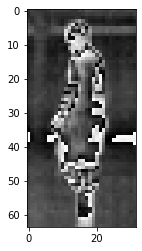

In [10]:
# visualize
plt.imshow(x_train[45001,:].reshape(64,32), cmap = "gray")

In [11]:
# %% 
num_classes = 2
# Hyper parameters
num_epochs = 100
batch_size = 2000
learning_rate = 0.0001

In [12]:
train = torch.utils.data.TensorDataset(x_train,y_train)
trainloader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

In [13]:
test = torch.utils.data.TensorDataset(x_test,y_test)
testloader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [14]:
def conv3x3(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        
def conv1x1(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride, bias = False)

In [15]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self,inplanes, planes, stride = 1, downsample = None):
        super(BasicBlock,self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace = True)
        self.drop = nn.Dropout(0.9)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes = num_classes):
        super(ResNet,self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride = 2, padding = 3, bias= False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
    
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity = "relu") # çok büyük ya da çok küçük sayıları değil 0'a yakın sayıları weightlere atıyor
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
                 
    def _make_layer(self, block, planes, blocks, stride = 1): # planes = input channel, blocks = basic block count
        downsample = None
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                    conv1x1(self.inplanes, planes*block.expansion, stride),
                    nn.BatchNorm2d(planes*block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes*block.expansion
        for _ in range(1,blocks):
            layers.append(block(self.inplanes, planes))
        
        return nn.Sequential(*layers)
        
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        
        return x

In [ ]:
model = ResNet(BasicBlock, [2,2,2])

# model = ResNet(BasicBlock, [2,2,2]).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
#%% train

loss_list = []
train_acc = []
test_acc = []
use_gpu = False

total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.view(batch_size,1,64,32)
        images = images.float()
        
        # gpu
        if use_gpu:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
            
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # backward and optimization
        optimizer.zero_grad() # gradietler sıfırlandı
        loss.backward()
        optimizer.step()
        
        if i % 2 == 0:
            print("epoch: {} {}/{}".format(epoch,i,total_step))

    # train
    correct = 0
    total = 0
    with torch.no_grad(): # update yok
        for data in trainloader:
            images, labels = data
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy train %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    # test
    correct = 0
    total = 0
    with torch.no_grad(): 
        for data in testloader:
            images, labels = data
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
                    
            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy test %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    loss_list.append(loss.item())


In [ ]:
#%% visualize

fig, ax1 = plt.subplots()
plt.plot(loss_list,label = "Loss",color = "black")
ax2 = ax1.twinx()
ax2.plot(np.array(test_acc)/100,label = "Test Acc",color="green")
ax2.plot(np.array(train_acc)/100,label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
fig.tight_layout()
plt.title("Loss vs Test Accuracy")
plt.show()

Bizim örneğimizde image shape 64x32. Padding değeri girmiyoruz, varsayılan değerini alıyor ki o da 0'a eşit. Stride değeri girmiyoruz, varsayılan değeri 1. Dilation değeri girmiyoruz, varsayılan değeri 1. Bu bilgileri toparladığımızda;

o = output = bilinmeyenimiz

p = padding = 0

k = kernel_size = 5

s = stride = 1

d = dilation = 1

i =input shape = 64x32

Bir Conv2d metoduna giren bir input aşağıdaki formüle göre çıkış boyutu verir.

o = [i + 2*p - k - (k-1)*(d-1)]/s + 1
Kendi parametre değerlerimizle çözüm yaptığımızda;

i=64 için o=60,

i=32 için o=28 çıkar. Böylece inputumuz ilk Conv2d metodundan çıktığında 60x28 shape'ini alıyor.

Ardından MaxPooling2d yapıyoruz. Örneğimizde pool_size=(2,2) belirlediğimiz için 60x28 shape'i 30x14'e indiriyoruz.

Ardından 30x14 için tekrar Conv2d uyguluyoruz.

i=30 için o=26,

i=14 için o=10, böylece inputumuz ikinci Conv2d metodundan çıktığında 26x10 shape'ini alıyor.

Ardından tekrar MaxPooling2d yapıyoruz. Örneğimizde pool_size=(2,2) belirlediğimiz için 26x10 shape'i 13x5'e indiriyoruz.

Son Conv2d metodunda feature map sayısını 16 olarak belirlediğimiz için elimizde 16 adet 13x5 image oluyor. Bu yüzden nn.Linear(16*13*5,520) yazıyoruz. Umarım faydalı olur.

In [ ]:
#%% IMAGE TO TEST
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
 
#image objesi olarak im değişkenine kayıt edilir.
im = Image.open('sekiz.jpg')
 
#image'ı numpy array'e dönüştürür
im2arr = np.array(im)
 
#image, im2arr içinde 28x28x3 formatında. Sondaki 3, channel değerini ifade ediyor. Channel=3 renkli yani r,g,b değerleri var anlamında. Biz modelimizi channel=1 yani gri'ye göre eğittik ve input_shape parametresini ona göre belirledik. Bu yüzden griye dönüştürerek 28x28x1 şekline getirmemiz gerekiyor.
 
def rgb2gray(rgb):
#image gray transform matris ile dot product yapıyor ve ch=1 yani 28x28 yani gri forma dönüşüyor. Fakat bize 28x28x1 şekli lazım. Predict öncesinde onu reshape yapacağız.
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
 
gray = rgb2gray(im2arr)
 
#gri image array'ından image objesi oluşturuluyor.
arr2im = Image.fromarray(gray)
 
#image plot ediliyor.
plt.imshow(arr2im)
plt.axis("off")
 
#yüklenen image'ın piksel değerleri normalize ediliyor ve predict için reshape yapılıyor
gray_norm = gray/255.0
gray_norm = gray_norm.reshape(28,28,1)
 
#%% TEST
 
#predict ve predictin olasılık değeri değişkenlere kaydediliyor.
y_head = model.predict_classes([[gray_norm]])
y_proba = model.predict_proba([[gray_norm]])
 
print("% {0:.2f} ihtimalle: ".format((y_proba[0,y_head[0]])*100), y_head[0])

In [ ]:
import pandas as pd
import cv2
import pickle
 
filenames = os.listdir("./train/malignant") # resimlerin bulunduğu klasör
images = []
i = 0
 
for filename in filenames:
	i += 1
	img = cv2.imread("./train/malignant/"+ filename)
	images.append(img)
	if i%100 == 0:
		print("{} Resim Yüklendi".format(i))
 
df = pd.DataFrame({
    'image': images
})
 
pickle_out = open("malignant_train.pickle","wb")
pickle.dump(df, pickle_out)
pickle_out.close()

pd.read_pickle('malignant_train.pickle')